##### modules version

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import pyhmmer
import pandarallel

for i in [pd, sns, matplotlib, np, pyhmmer, pandarallel]:
    print(i.__name__, i.__version__)

! hmmsearch -h | head -n 10

pandas 1.3.4
seaborn 0.12.2
matplotlib 3.4.3
numpy 1.22.3
pyhmmer 0.6.3
pandarallel 1.6.1
# hmmsearch :: search profile(s) against a sequence database
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Usage: hmmsearch [options] <hmmfile> <seqdb>

Basic options:
  -h : show brief help on version and usage



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=2.0)
sns.set_style('whitegrid')
import numpy as np

aa = 'FCYQLNGIPRADEHKMSTWV'


import pyhmmer
pyhmmer.__version__

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


'0.6.3'

In [2]:
db = 'data/uniprot-compressed_true_download_true_fields_accession_2Creviewed_2C-2022.10.24-11.09.16.67.tsv.gz'

uniprot = pd.read_csv(db, sep='\t')
uniprot = uniprot[uniprot.Sequence.str.len() <= uniprot.Sequence.str.len().quantile(0.99)].copy()
uniprot = uniprot.reset_index(drop=True)
uniprot.Sequence = uniprot.Sequence.str.replace('U', 'C')
uniprot.head(2)

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Protein families,Subcellular location [CC],PubMed ID,Sequence
0,A0A087X1C5,reviewed,CP2D7_HUMAN,Putative cytochrome P450 2D7 (EC 1.14.14.1),CYP2D7,Homo sapiens (Human),515,Cytochrome P450 family,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,15051713; 10591208; 16169517; 17494644; 18838503,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
1,A0A0B4J2F0,reviewed,PIOS1_HUMAN,Protein PIGBOS1 (PIGB opposite strand protein 1),PIGBOS1,Homo sapiens (Human),54,NaN,SUBCELLULAR LOCATION: Mitochondrion outer memb...,14702039; 16572171; 31653868,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...


In [3]:
uniprot.shape

(20181, 11)

In [4]:
uniprot['Length'] = uniprot.Sequence.str.len()
uniprot.Length.describe(), uniprot.Length.median()

(count    20181.000000
 mean       521.937070
 std        409.817688
 min          2.000000
 25%        248.000000
 50%        411.000000
 75%        660.000000
 max       2723.000000
 Name: Length, dtype: float64,
 411.0)

In [10]:
# uniprot[uniprot['Length'] < 15].shape

(4, 11)

#### Length distribution

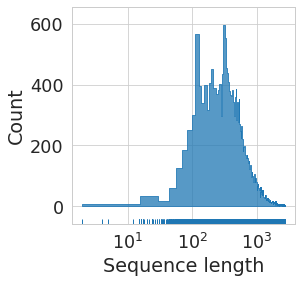

In [6]:


plt.figure(figsize=(4, 4))

sns.rugplot(data=uniprot['Length'])
ax = sns.histplot(data=uniprot['Length'], bins=200, element='step',
                 kde=False)

ax.set_xlabel('Sequence length')
ax.set_xscale('log');

### Frequency of AAs

In [7]:
from collections import Counter

all_seqs = ''.join(uniprot.Sequence)
counts = Counter(all_seqs)

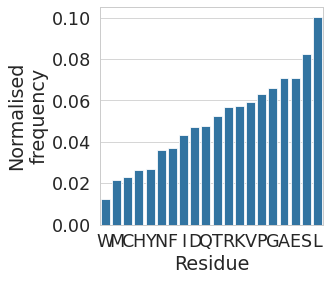

In [8]:
count_df = pd.DataFrame.from_dict(counts, orient='index')
count_df = count_df.sort_values(0)
count_df['Normalised\nfrequency'] = count_df[0]/count_df[0].sum()

plt.figure(figsize=(4, 4))

ax = sns.barplot(data=count_df.reset_index(), x='index',
                y='Normalised\nfrequency', color='#1f77b4')
ax.set_xlabel('Residue');

In [9]:
''.join(count_df.index[::-1])

'LSEAGPVKRTQDIFNYHCMW'

In [10]:
sorted_freq_aa = []

temp_str = ''
for i in'LSEAGPVKRTQDIFNYHCMW':
    
    temp_str += i
    sorted_freq_aa.append(temp_str)
sorted_freq_aa

['L',
 'LS',
 'LSE',
 'LSEA',
 'LSEAG',
 'LSEAGP',
 'LSEAGPV',
 'LSEAGPVK',
 'LSEAGPVKR',
 'LSEAGPVKRT',
 'LSEAGPVKRTQ',
 'LSEAGPVKRTQD',
 'LSEAGPVKRTQDI',
 'LSEAGPVKRTQDIF',
 'LSEAGPVKRTQDIFN',
 'LSEAGPVKRTQDIFNY',
 'LSEAGPVKRTQDIFNYH',
 'LSEAGPVKRTQDIFNYHC',
 'LSEAGPVKRTQDIFNYHCM',
 'LSEAGPVKRTQDIFNYHCMW']

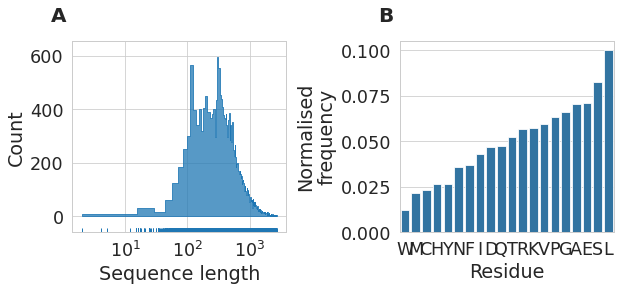

In [11]:
fig, ax = plt.subplot_mosaic('AB', figsize=(9, 4.5))
# ax = ax.flatten()

sns.rugplot(data=uniprot['Length'], ax=ax['A'])
sns.histplot(data=uniprot['Length'], bins=200, element='step',
                 kde=False, ax=ax['A'])

ax['A'].set_xlabel('Sequence length')
ax['A'].set_xscale('log');


sns.barplot(data=count_df.reset_index(), x='index',
                y='Normalised\nfrequency', color='#1f77b4', ax=ax['B'])
ax['B'].set_xlabel('Residue')

for n, (key, a) in enumerate(ax.items()):
    a.text(-0.1, 1.1, key, transform=a.transAxes, 
            size=20, weight='bold')


plt.tight_layout();

### Export data

In [12]:
tmp_df = uniprot[['Entry', 'Sequence']].copy()
tmp_df.Entry = '>' + tmp_df.Entry

tmp_df.to_csv('data/uniprot-9606.fasta', header=None, 
              index=None, sep='\n')
tmp_df.shape

(20181, 2)

In [13]:
! head data/uniprot-9606.fasta

>A0A087X1C5
MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNLLHVDFQNTPYCFDQLRRRFGDVFSLQLAWTPVVVLNGLAAVREAMVTRGEDTADRPPAPIYQVLGFGPRSQGVILSRYGPAWREQRRFSVSTLRNLGLGKKSLEQWVTEEAACLCAAFADQAGRPFRPNGLLDKAVSNVIASLTCGRRFEYDDPRFLRLLDLAQEGLKEESGFLREVLNAVPVLPHIPALAGKVLRFQKAFLTQLDELLTEHRMTWDPAQPPRDLTEAFLAKKEKAKGSPESSFNDENLRIVVGNLFLAGMVTTSTTLAWGLLLMILHLDVQRGRRVSPGCPIVGTHVCPVRVQQEIDDVIGQVRRPEMGDQAHMPCTTAVIHEVQHFGDIVPLGVTHMTSRDIEVQGFRIPKGTTLITNLSSVLKDEAVWKKPFRFHPEHFLDAQGHFVKPEAFLPFSAGRRACLGEPLARMELFLFFTSLLQHFSFSVAAGQPRPSHSRVVSFLVTPSPYELCAVPR
>A0A0B4J2F0
MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLVQESEEKKS
>A0A0B4J2F2
MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARHRVTKTQVAIKIIDKTRLDSSNLEKIYREVQLMKLLNHPHIIKLYQVMETKDMLYIVTEFAKNGEMFDYLTSNGHLSENEARKKFWQILSAVEYCHDHHIVHRDLKTENLLLDGNMDIKLADFGFGNFYKSGEPLSTWCGSPPYAAPEVFEGKEYEGPQLDIWSLGVVLYVLVCGSLPFDGPNLPTLRQRVLEGRFRIPFFMSQDCESLIRRMLVVDPARRITIAQIRQHRWMRAEPCLPGPACPAFSAHSYTSNLGDYDEQALGIMQTLGVDRQRTVESLQNSSYNHFAAIYYLLLERLKEYRNAQCARPGPARQPRPRSSDLSGLEVPQEGLSTDPFRPALLCPQP

In [13]:
uniprot.shape, pd.read_csv(db, sep='\t').shape

((20181, 11), (20385, 11))